# Introduction

This notebook aims to develop a model that predicts ice formation on sidewalk/road surfaces using basic weather data including temperature, dew point temperature, wind speed, and gust speed. The model is trained on data from Road Weather Information Stations (RWIS).

Two models are being evaluated:
- Long Short-Term Memory (LSTM) Network
- Logistic Regression

# Download Dataset from RWIS API

In [2]:
import requests
import pandas as pd
import numpy as np
import os

In [4]:

url = "https://mesonet.agron.iastate.edu/cgi-bin/request/rwis.py"
network = "VT_RWIS" # Vermont
stations = "_ALL" # Select All Stations
format = "txt"
start = "2015-01-01T00:00" # Start Timestamp
end = "2025-01-01T00:00" # End Timestamp
tz = "America%2FNew_York" # Timezone
src = "atmos" # atmospheric data

api_url = (
    f"{url}?"
    f"network={network}&"
    f"stations={stations}&"
    f"tz={tz}&"
    f"what={format}&"
    f"src={src}&"
    f"sts={start}&"
    f"ets={end}"
)

output_filename = 'rwis_vt.txt'
print("GET: " + api_url)

try:
  response = requests.get(api_url)

  response.raise_for_status()

  # Create directory if it doesn't exist
  output_dir = 'content/dataset'
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  # Define the output file path
  output_file = os.path.join(output_dir, output_filename)

  # Write the content to a file
  with open(output_file, 'wb') as f:
      f.write(response.content)

  print(f"File successfully downloaded to: {output_file}")

except requests.exceptions.RequestException as e:
        print(f"Error making API request: {e}")
except Exception as e:
    print(f"Error: {e}")

GET: https://mesonet.agron.iastate.edu/cgi-bin/request/rwis.py?network=VT_RWIS&stations=_ALL&tz=America%2FNew_York&what=txt&src=atmos&sts=2015-01-01T00:00&ets=2025-01-01T00:00
File successfully downloaded to: content/dataset/rwis_vt.txt


# Process Dataset

We're focusing on the following columns:

* **tmpf** - Temperature in Fahrenheit
* **dwpf** - Dew point temperature in Fahrenheit
* **sknt** - Wind speed in knots
* **gust** - Gust wind speed in knots
* **surface conditions** (represented by **tfs0_text**, **tfs1_text**, **tfs2_text**, **tfs3_text**)

For comprehensive documentation on the database, please visit: https://mesonet.agron.iastate.edu/request/rwis/fe.phtml

In [7]:
output_file = 'content/dataset/rwis_vt.txt'
df = pd.read_csv(output_file, delimiter=',', low_memory=False)
print("\nData Preview:")
print(df.head())


Data Preview:
  station    tmpf     dwpf   drct      sknt  tfs0    tfs1    tfs2    tfs3  \
0   VT008  21.218  5.73800  230.0  34.96500   NaN     NaN     NaN     NaN   
1   VT006  21.038  4.65798  215.0  19.42500   NaN     NaN     NaN     NaN   
2   VT013  22.658  8.25798  202.0  25.25250   NaN     NaN     NaN  18.338   
3   VT002  18.698  6.45798  260.0  36.90750   NaN     NaN     NaN     NaN   
4   VT004  17.438  3.39802  245.0   5.82751   NaN  15.998  16.718     NaN   

   subf     gust tfs0_text  tfs1_text tfs2_text tfs3_text      pcpn  vsby  \
0   NaN  60.2176       NaN        NaN       NaN       NaN  0.000000   NaN   
1   NaN  58.2751       NaN        NaN       NaN       NaN  0.015748   NaN   
2   NaN  38.8500       NaN        NaN       NaN       NaN       NaN   NaN   
3   NaN  75.7576       NaN        NaN       NaN       NaN  0.003937   NaN   
4   NaN  19.4250       NaN        NaN       NaN       NaN  0.007874   NaN   

   feel  relh               obtime  
0   NaN   NaN  2015-01

## Basic Data Processing

In addition to the existing columns, we derived the following features from the timestamp:

* **year** - Integer value of the year
* **month** - Integer value (1-12) representing the month
* **iswinter** - Binary indicator (0 or 1) where 1 represents winter months
* **isday** - Binary indicator (0 or 1) where 1 represents daytime and 0 represents nighttime

In [8]:
df['obtime'] = df['obtime'].astype(str)
df['obtime'] = pd.to_datetime(df['obtime'], format='%Y-%m-%d %H:%M:%S')
df['year'] = df['obtime'].dt.year
df['month'] = df['obtime'].dt.month
df['iswinter'] = df['month'].isin([12, 1, 2, 3]).astype(int) 
df['isday'] = ((df['obtime'].dt.hour >= 6) & (df['obtime'].dt.hour <= 18)).astype(int)

In [9]:
df = df.drop(df[(df['iswinter'] == 0)].index) # drop all months besides Nov to Mar
df = df.dropna(subset=['tmpf', 'dwpf', 'gust', 'sknt', 'obtime']) # Drop all rows with NaN values

## Station Unique ID

New column: **stationid**

This identifier is created to associate each station with its respective winter season. 
For example: **VT019-19-20** represents data from station **VT019** during the winter season of 2019-2020.

In [10]:
# Return an ID for the winter season with the station ID

def get_winter(row):
    if row['month'] in [11, 12]:  # If month is Nov or Dec
        winter = f"{row['station']}-{str(row['year'])[2:]}-{str(row['year']+1)[2:]}"
    else:  # If month is Jan, Feb, or Mar
        winter = f"{row['station']}-{str(row['year']-1)[2:]}-{str(row['year'])[2:]}"
    return winter

df['stationid'] = df.apply(get_winter, axis=1) # Create a cluster ID for each winter season at each station

## Relative Humidity

New column: **rh**

This represents relative humidity, calculated using **tmpf** and **dwpf** (temperature and dew point temperature).
The calculation follows the equation from: https://www.omnicalculator.com/physics/relative-humidity

In [11]:
def calc_rh(tmpf, dwpf):
    e_ta = 6.112 * np.exp((17.625 * (tmpf - 32) * 5.0/9.0) / ((tmpf - 32) * 5.0/9.0 + 243.04))
    e_td = 6.112 * np.exp((17.625 * (dwpf - 32) * 5.0/9.0) / ((dwpf - 32) * 5.0/9.0 + 243.04))

    rh = 100 * (e_td / e_ta)
    return rh

df['rh'] = calc_rh(df['tmpf'], df['dwpf']) # Calculate relative humidity

## Surface Conditions

New column: **conditions** <br>
Calculated using the majority vote from **tfs0_text, tfs1_text, tfs2_text, tfs3_text**

In [12]:
# Many stations have multiple ground condition sensors, so we need to find the most common value
# For example: (Wet, NaN, Wet) should be Wet
def fast_majority_vote(df, cols):
    def get_mode(row):
        # Get value counts of non-NaN values
        counts = row.value_counts()
        if len(counts) == 0:
            return np.nan
        # Check if most common value appears more than half of non-NaN values
        if counts.iloc[0] > row.count()/2:
            return counts.index[0]
        return np.nan

    return df[cols].apply(get_mode, axis=1)

df['conditions'] = fast_majority_vote(df, ['tfs0_text', 'tfs1_text', 'tfs2_text', 'tfs3_text']) # Get most common ground condition
df = df.dropna(subset=['conditions']) # Drop rows with NaN values in conditions

In [13]:
condtion_unique = df['conditions'].unique()
print("Unique Surface Condition", condtion_unique)

Unique Surface Condition ['Dry' 'Wet' 'Moist' 'Snow/Ice Watch' 'Frost' 'Snow/Ice Warning'
 'Wet Below Freezing' 'Slush']


## Ice Surface Condition

New column: **isice**

Calculated using **conditions**

In [14]:
df['isice'] = df['conditions'].str.contains('Ice|Frost|Slush', case=False).astype(int) # 1 if ice or frost, 0 if not

In [15]:
ice_count = df['isice'].value_counts()
print(ice_count)

isice
0    681332
1     85136
Name: count, dtype: int64


## Sort:  Station ID and Time

For sequential data

Group 1:
```
VT02-20-21 ...... 2020-11-01 00:05:02
VT02-20-21 ...... 2020-11-01 00:35:02
......
```

Group 2
```
VT01-20-21 ...... 2020-11-01 00:05:02
VT01-20-21 ...... 2020-11-01 00:35:02
.......
```





In [16]:
df = df.sort_values(['stationid', 'obtime'])

## Time Difference

New columns: **tdiff**

Calculated using **obtime**, by comparing the time difference between the current and previous rows

RWIS dataset have an inconsistent interval between different weather records. For example, an interval may look like this in a station:
10min, 20min, 15 min ....

LSTM model assume the interval to be constant, so we include tdiff as a feature in the model instead.

In [17]:
df['tdiff'] = df['obtime'].diff().dt.total_seconds() / 60 # to minute
df['tdiff'] = df['tdiff'].fillna(0)

In [18]:
df = df.drop(df[(df['tdiff'] > 60) | (df['tdiff'] < 0)].index) # Drop rows with time difference greater than 60 minutes
df['tdiff'] = df['obtime'].diff().dt.total_seconds() / 60 # to minute
df['tdiff'] = df['tdiff'].fillna(0)

## Group by Station ID

In [19]:
df = df.groupby('stationid').filter(lambda x: len(x) >= 100)
station = df['stationid'].unique()
counts = df.groupby('stationid').size()

## Output

In [20]:
output = df[['stationid', 'tmpf', 'dwpf', 'rh', 'sknt','gust', 'tdiff', 'conditions', 'isday',  'isice']]

In [21]:
output.sample(4)

,stationid,tmpf,dwpf,rh,sknt,gust,tdiff,conditions,isday,isice
3938412,VT005-23-24,32.360012,25.699990,76.184086,6.414687,12.051835,100.0,Wet,1,0
2343952,VT025-21-22,35.419980,43.340023,136.153151,2.526998,3.304535,35.0,Wet,1,0
3042123,VT011-22-23,22.280000,21.380000,96.270713,4.276458,8.552916,25.0,Dry,1,0
3037532,VT034-22-23,23.360010,17.599989,78.286525,7.775378,11.468682,30.0,Dry,1,0


Make sure the output doesn't have any NA values. Otherwise the model won't be happy.

In [22]:
print(output.isna().any().any())
columns_with_nan = output.columns[output.isna().any()].tolist()
print(columns_with_nan)

False
[]


In [23]:
output_dir = 'content/clean'
if not os.path.exists(output_dir):
  os.makedirs(output_dir)
output.to_csv(output_dir+'/vt.csv')

# LSTM Model

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [27]:
data = pd.read_csv('content/clean/vt.csv', sep=',')

In [28]:
features = ['tmpf', 'rh', 'sknt', 'gust', 'tdiff', 'isday']
target = 'isice'
X = data[features].values
y = data[target].values

## Normalization

Normalization is a crucial preprocessing step that scales all features to a common range, preventing any single feature from dominating the model due to its magnitude. For this analysis, we use **StandardScaler**.

For example, instead of temperature (**tmpf**) ranging from -20°F to 60°F, standardization converts these values to approximately -2.5 to 2.5, representing z-scores calculated using the sample mean and standard deviation. This ensures no column has disproportionate influence on the model.

An alternative approach would be to use MinMaxScaler, which scales features to a specific range (typically 0 to 1).

For more information on StandardScaler, see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [29]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Class Imbalance Handling

In [30]:
ice_count = df['isice'].value_counts()
print(ice_count)

isice
0    676117
1     84040
Name: count, dtype: int64


Our target variable *isice* appears in only approximately 11% of the dataset, creating a significant class imbalance. To address this issue and improve model training, we resampled our input data to achieve a more balanced distribution where positive cases (*isice* = 1) represent approximately 50% of the training data.

In [31]:
def get_event_windows(X, y, sequence_length, window_size, include_non_events=True):
    """
    Extract windows around ice events (where y=1) and optionally include some non-event periods

    Parameters:
    -----------
    X : array-like
        Input features
    y : array-like
        Target values
    sequence_length : int
        Length of each sequence
    window_size : int
        Number of time steps before and after an event to include
    include_non_events : bool
        Whether to include some non-event periods
    """
    event_indices = np.where(y == 1)[0]
    X_windows = []
    y_windows = []

    # Get sequences around events
    for idx in event_indices:
        # Define window boundaries
        start = max(0, idx - window_size)
        end = min(len(X), idx + window_size)

        # Extract sequences within this window
        for i in range(start, end - sequence_length):
            X_windows.append(X[i:(i + sequence_length)])
            y_windows.append(y[i + sequence_length])

    if include_non_events:
        # Get some non-event sequences (randomly sampled)
        non_event_indices = np.where(y == 0)[0]
        # Sample same number of non-events as events
        sample_size = min(len(event_indices) * window_size, len(non_event_indices))
        sampled_indices = np.random.choice(non_event_indices, size=sample_size, replace=False)

        for idx in sampled_indices:
            if idx + sequence_length < len(X):
                X_windows.append(X[idx:(idx + sequence_length)])
                y_windows.append(y[idx + sequence_length])

    return np.array(X_windows), np.array(y_windows)

In [32]:
# Parameters
sequence_length = 10
window_size = 24

X_sequences = []
y_sequences = []

# Group by station and get sequences around events
for station in df['stationid'].unique():
    station_mask = df['stationid'] == station
    station_X = X_scaled[station_mask]
    station_y = y[station_mask]

    # Get sequences around events
    X_event, y_event = get_event_windows(station_X, station_y,
                                        sequence_length,
                                        window_size,
                                        include_non_events=True)

    if len(X_event) > 0:
        X_sequences.extend(X_event)
        y_sequences.extend(y_event)

# Convert to numpy arrays
X_sequences = np.array(X_sequences, dtype='float32')
y_sequences = np.array(y_sequences, dtype='float32')

# Print information about the dataset
print("Final shapes:")
print("X_sequences shape:", X_sequences.shape)
print("y_sequences shape:", y_sequences.shape)
print("\nClass distribution:")
print(np.bincount(y_sequences.astype(int)))
print("\nPercentage of ice events:", np.mean(y_sequences) * 100, "%")

# Optional: Shuffle the data
indices = np.arange(len(X_sequences))
np.random.shuffle(indices)
X_sequences = X_sequences[indices]
y_sequences = y_sequences[indices]

Final shapes:
X_sequences shape: (3827751, 10, 6)
y_sequences shape: (3827751,)

Class distribution:
[1707261 2120490]

Percentage of ice events: 55.39780259132385 %


## Training/Testing Split

In [33]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42
)

## Build Model

In [34]:
# Build LSTM Model

model = Sequential([
    LSTM(128, input_shape=(sequence_length, len(features)), return_sequences=True), 
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/miniconda3/envs/engs90/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,153 (473.25 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 0 (0.00 B)

## Train

In [35]:
history = model.fit(X_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2,
                   verbose=1)

Epoch 1/10
76555/76555 ━━━━━━━━━━━━━━━━━━━━ 497s 6ms/step - accuracy: 0.7606 - loss: 0.5047 - val_accuracy: 0.8175 - val_loss: 0.4029
Epoch 2/10
76555/76555 ━━━━━━━━━━━━━━━━━━━━ 473s 6ms/step - accuracy: 0.8253 - loss: 0.3888 - val_accuracy: 0.8702 - val_loss: 0.3087
Epoch 3/10
76555/76555 ━━━━━━━━━━━━━━━━━━━━ 486s 6ms/step - accuracy: 0.8654 - loss: 0.3159 - val_accuracy: 0.8938 - val_loss: 0.2629
Epoch 4/10
76555/76555 ━━━━━━━━━━━━━━━━━━━━ 493s 6ms/step - accuracy: 0.8863 - loss: 0.2758 - val_accuracy: 0.9080 - val_loss: 0.2345
Epoch 5/10
76555/76555 ━━━━━━━━━━━━━━━━━━━━ 522s 7ms/step - accuracy: 0.8981 - loss: 0.2520 - val_accuracy: 0.9152 - val_loss: 0.2199
Epoch 6/10
76555/76555 ━━━━━━━━━━━━━━━━━━━━ 542s 7ms/step - accuracy: 0.9064 - loss: 0.2350 - val_accuracy: 0.9233 - val_loss: 0.2025
Epoch 7/10
76555/76555 ━━━━━━━━━━━━━━━━━━━━ 579s 8ms/step - accuracy: 0.9124 - loss: 0.2224 - val_accuracy: 0.9272 - val_loss: 0.1935
Epoch 8/10
76555/76555 ━━━━━━━━━━━━━━━━━━━━ 550s 7ms/step - ac

## Result

### Evaluation on Test Dataset

In [36]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_accuracy:.3f}')

23924/23924 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.9371 - loss: 0.1691

Test accuracy: 0.937


### Confusion Matrix

23924/23924 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step


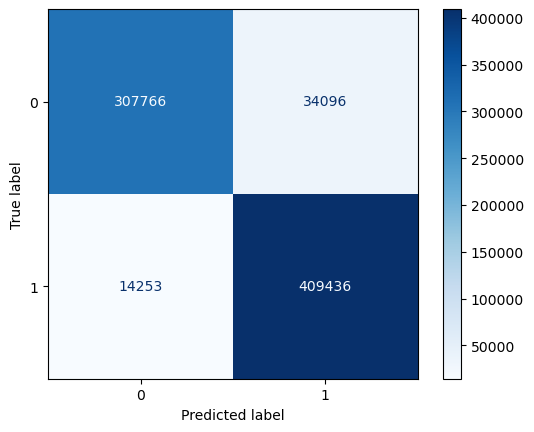

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Make sure both y_test and y_pred are in the same format
y_test = y_test.astype(int)
y_pred = (y_pred > 0.5).astype(int) # Convert probabilities to binary predictions

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

## Save Model

In [39]:
import joblib

# Save Model
model.save('content/result/model_lstm.keras')
print("Model saved to content/result/model_lstm.keras")

# Save Scaler file
joblib.dump(scaler, 'content/result/scaler_lstm.pkl')
print("Scaler saved to content/result/scaler_lstm.pkl")


Model saved to content/result/model_lstm.keras
Scaler saved to content/result/scaler_lstm.pkl


# How to use the existing weather data to predict ice formation

In [40]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

import numpy as np
import joblib

model = load_model('content/result/model_lstm.keras')

scaler = joblib.load('content/result/scaler_lstm.pkl')

features = ['tmpf', 'rh', 'sknt', 'gust', 'tdiff', 'isday']

# Example data with sequence of two time steps
data = [[32.2, 91, 0, 2, 0, 1],
        [32.2, 91, 0, 2, 10, 1]]

X = np.array(data, dtype='float32')
X_scaled = scaler.transform(X)

sequence_length = len(data)

res = model.predict(X_scaled.reshape(1, sequence_length, len(features)))
print(res[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
0.0028481649


# Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [42]:
data = pd.read_csv('content/clean/vt.csv', sep=',')

features = ['tmpf', 'rh', 'sknt', 'gust', 'tdiff', 'isday']
target = 'isice'

X = data[features].values
y = data[target].values

## Train/Test Split

In [43]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Normalization

In [44]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Resample

**isice** only showed about 11% of the dataset. We want to resample to about 50%

In [45]:
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [46]:
ice_count = pd.Series(y_train_resampled).value_counts()
print(ice_count)

0    540988
1    540988
Name: count, dtype: int64


## Model

In [47]:
model = LogisticRegression(random_state=42)

## Train

In [48]:
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

## Results

In [53]:
res = model.score(X_test_scaled, y_test)
print("Accuracy Rate:", res)

Accuracy Rate: 0.7393838139339086


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83    135129
           1       0.27      0.82      0.41     16903

    accuracy                           0.74    152032
   macro avg       0.62      0.77      0.62    152032
weighted avg       0.89      0.74      0.79    152032



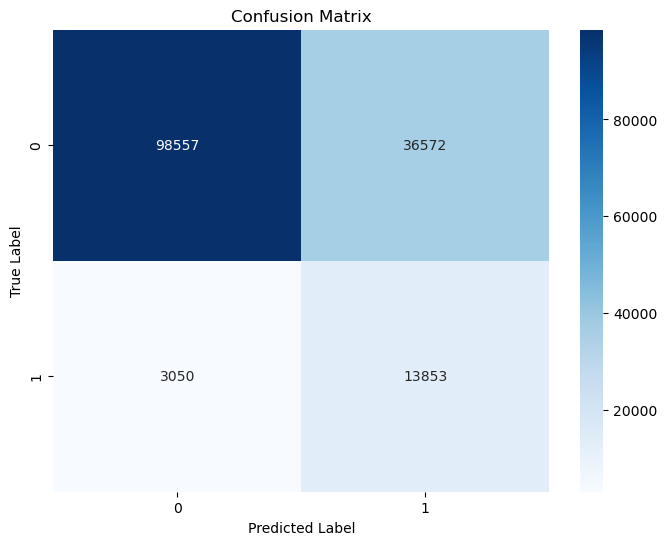

In [54]:
# Make predictions
y_pred = model.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))

y_pred = (y_pred > 0.5).astype(int) # Convert probabilities to binary predictions

# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

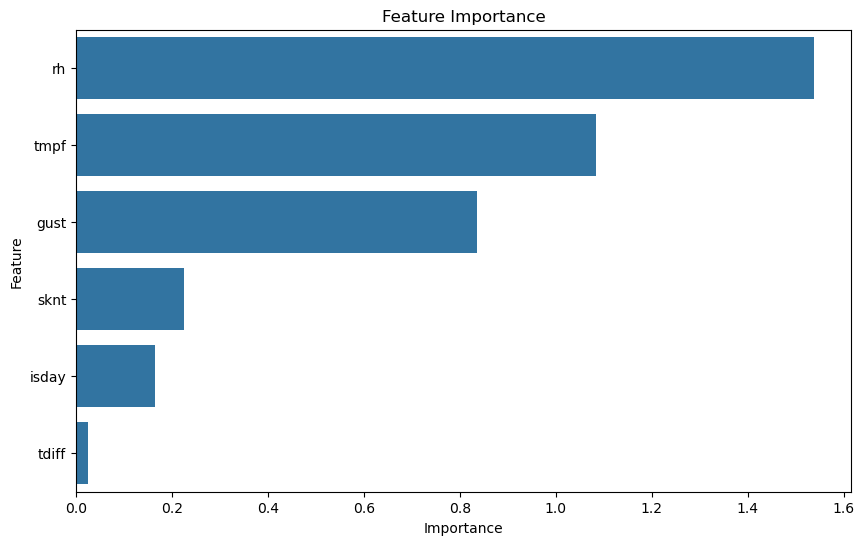

In [55]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [56]:
# Print model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(features, model.coef_[0]):
    print(f"{feature}: {coef:.4f}")


Model Coefficients:
tmpf: -1.0829
rh: 1.5382
sknt: -0.2244
gust: 0.8361
tdiff: 0.0243
isday: -0.1635
